In [1]:
import math
import numpy as np
import sys
import os
import uproot
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy import stats, optimize
import pylandau
from pathlib import Path

In [2]:
# from funs import *

plt.rcParams["font.size"]=10
plt.rcParams["axes.labelsize"]=12
plt.rcParams["figure.dpi"]=200
plt.rcParams['figure.figsize'] = [6, 4]

In [3]:
%%capture

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')



In [4]:
### get data ###

inFileName = "../Root_outputs/anaCTHSimG4_4e7POT_id5.root"
outFileName = "{}.txt".format(Path(inFileName).stem)
file = uproot.open(inFileName)

tree = file['tree_CTH']
tree_arr = tree.arrays()

x = np.array(tree_arr["x"])
y = np.array(tree_arr["y"])
z = np.array(tree_arr["z"])
px = np.array(tree_arr["px"])
py = np.array(tree_arr["py"])
pz = np.array(tree_arr["pz"])
t = np.array(tree_arr["t"])

seg = np.array(tree_arr["seg"])
hod = np.array(tree_arr["hod"])
cry = np.array(tree_arr["cry"])

ix = np.array(tree_arr["ix"])
iy = np.array(tree_arr["iy"])
iz = np.array(tree_arr["iz"])
ipx = np.array(tree_arr["ipx"])
ipy = np.array(tree_arr["ipy"])
ipz = np.array(tree_arr["ipz"])
it = np.array(tree_arr["it"])

ox = np.array(tree_arr["ox"])
oy = np.array(tree_arr["oy"])
oz = np.array(tree_arr["oz"])
opx = np.array(tree_arr["opx"])
opy = np.array(tree_arr["opy"])
opz = np.array(tree_arr["opz"])
ot = np.array(tree_arr["ot"])

pid = np.array(tree_arr["iPid"])
trackid = np.array(tree_arr["TrackId"])
nodeid = np.array(tree_arr["nodeId"])
dE = np.array(tree_arr["dE"])
Len = np.array(tree_arr["len"])
dEcorr = np.array(tree_arr["dEcorr"])
opid = np.array(tree_arr["oPid"])

iprocess = np.array(tree_arr["iProcess"])
# oprocess = tree_arr["oProcess"]


In [5]:
omin = -10000
ox = ox[ox>omin]
oy = oy[oy>omin]
oz = oz[oz>omin]
opx = opx[opx>omin]
opy = opy[opy>omin]
opz = opz[opz>omin]
ot = ot[ot>omin]

In [6]:
x0, y0, z0 = 6670, 0, 7650  ## CTH center / origin of CTH coord system

# cartesian coordinates in CTH system
xc = x-x0
yc = y-y0
zc = z-z0

# polar coordinates in CTH system
rho = ((y-y0)**2 + (z-z0)**2)**0.5
# irho = (iy**2 + iz**2)**0.5
# orho = (oy**2 + oz**2)**0.5
phi = np.arctan2(z-z0, y-y0)
# iphi = np.arctan2(iy, iz)
# ophi = np.arctan2(oy, oz)

p2 = np.sqrt(px**2 + py**2 + pz**2)
ip2 = np.sqrt(ipx**2 + ipy**2 + ipz**2)
op2 = np.sqrt(opx**2 + opy**2 + opz**2)

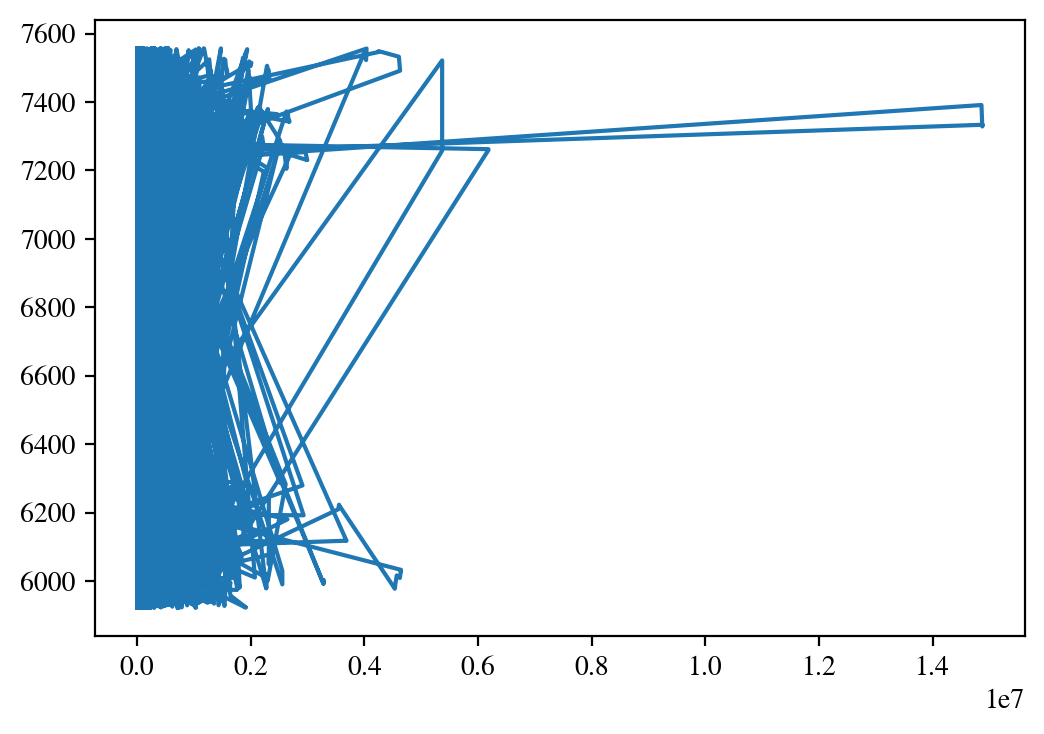

In [7]:
plt.plot(t, x)

In [8]:
np.mean(x), np.mean(y), np.mean(z)

(6671.414469823883, 0.3004262269619317, 7651.262989034133)

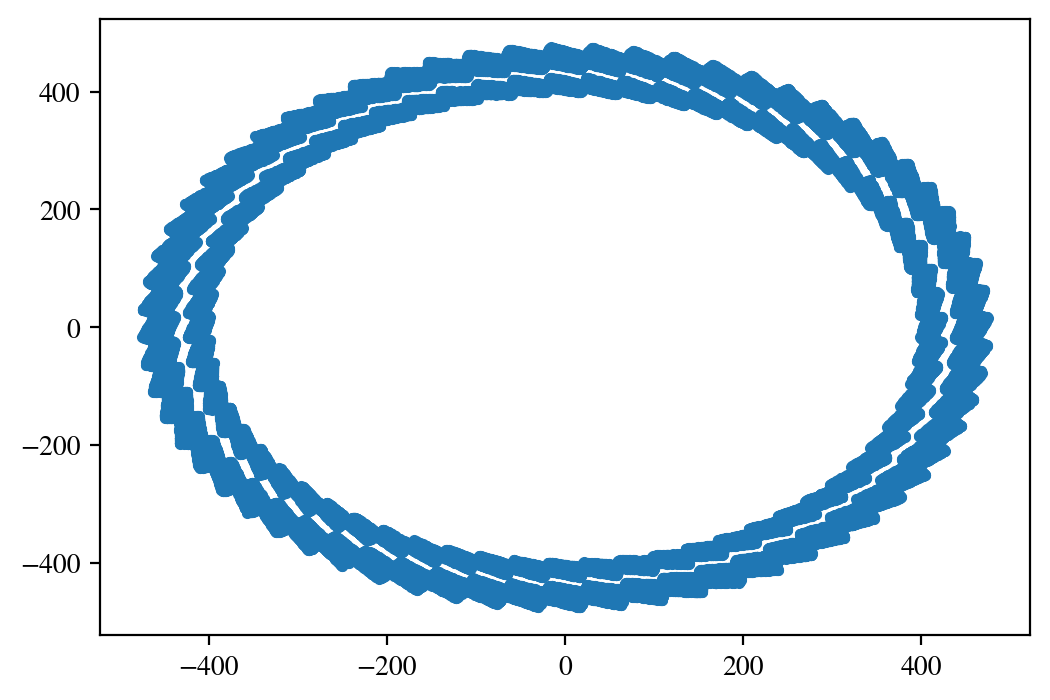

In [9]:
plt.plot(yc, zc, '.')

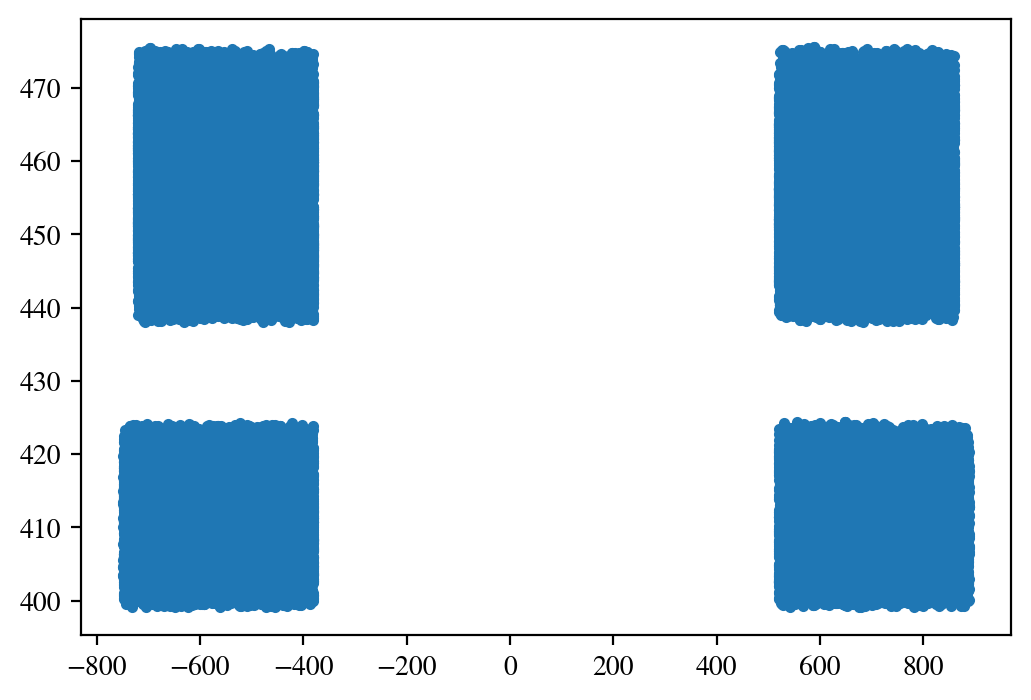

In [10]:
plt.plot(xc, rho, '.')
# plt.ylim(0, 500)

(<a list of 2 Line2D ticklines objects>, [Text(0.0, 0, '0°')])

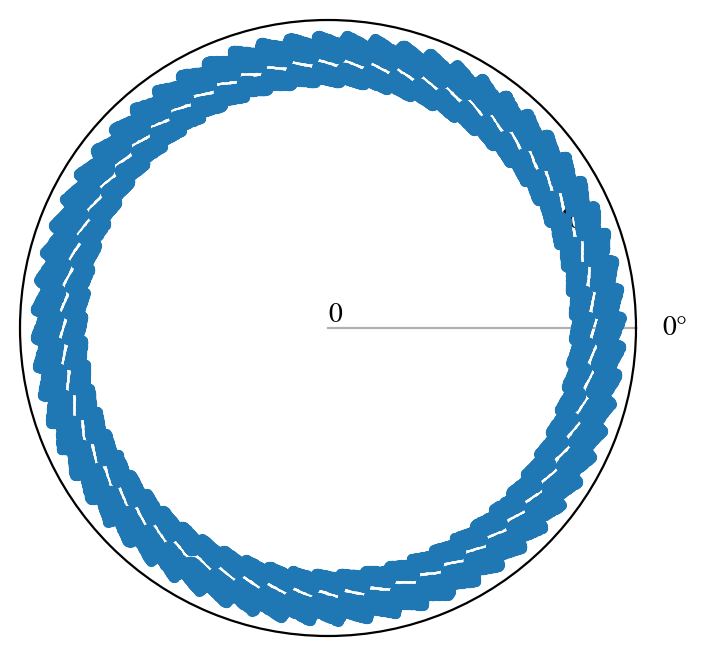

In [11]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phi, rho, '.')
ax.set_rmax(500)
ax.set_rticks([0, 400])  # Less radial ticks
# ax.set_theticks([200, 400, 600])  # Less radial ticks
ax.set_thetagrids([0])
# ax.
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True)

In [12]:
Nhits = len(x)
Nprimary = len(ix)
Nparents = len(ox)

ptypes = {}
for idd in pid:
	if idd not in ptypes.keys():
		ptypes[idd] = 1
	else:
		ptypes[idd] += 1
ptypes = dict(sorted(ptypes.items()))
print(ptypes)
print(Nhits, Nprimary, Nparents)


{-11.0: 200, 11.0: 11462, 22.0: 8559, 2212.0: 89098, 1000010020.0: 331, 1000020040.0: 22, 1000040080.0: 4, 1000040090.0: 9, 1000050100.0: 1, 1000050110.0: 5, 1000060120.0: 20567, 1000060130.0: 230}
130488 130488 130488


In [13]:
optypes = {}
for idd in opid:
	if idd not in optypes.keys():
		optypes[idd] = 1
	else:
		optypes[idd] += 1
optypes = dict(sorted(optypes.items()))
print(optypes)

{-211.0: 19, -11.0: 2808, 11.0: 3275, 13.0: 1737, 22.0: 11284, 2112.0: 111362, 2212.0: 3}


In [14]:
protonOrigins = {}
gammaOrigins = {}
elecOrigins = {}

for i in range(Nhits):
    iid = pid[i]
    oid = opid[i]
    if iid==2212:
        if oid not in protonOrigins.keys():
            protonOrigins[oid] = 1
        else:
            protonOrigins[oid] += 1
    elif iid==22:
        if oid not in gammaOrigins.keys():
            gammaOrigins[oid] = 1
        else:
            gammaOrigins[oid] += 1
    elif iid==11:
        if oid not in elecOrigins.keys():
            elecOrigins[oid] = 1
        else:
            elecOrigins[oid] += 1
protonOrigins = dict(sorted(protonOrigins.items()))
gammaOrigins = dict(sorted(gammaOrigins.items()))
elecOrigins = dict(sorted(elecOrigins.items()))

In [15]:
protonOrigins, gammaOrigins, elecOrigins

({22.0: 3, 2112.0: 89095},
 {-211.0: 19,
  -11.0: 2752,
  11.0: 2957,
  13.0: 1669,
  22.0: 11,
  2112.0: 1149,
  2212.0: 2},
 {-11.0: 56, 11.0: 318, 13.0: 68, 22.0: 11020})

In [1]:
# 11: electron
# 13: muon
# 22: photon
# 2112: neutron
# 2212: proton
# 1000010020: deuterium

In [17]:
npot = 4e7 ## number of protons on target

### constants
protonRate = 2.5e12 ## number of protons per second
bunchDt = 1316e-9 ## average bunch duration
npotPerBunch = 1.63e7 ## numbers of pot per bunch

simTime0 = npot/protonRate ## hits per sec method (old)
simTime =  (npot/npotPerBunch) * bunchDt  ## hits per bunch method

print("{:.2e}".format(simTime0))
print("{:.2e}".format(simTime))

totalHitRate = Nhits/simTime
hitRatePerCounter = totalHitRate/256

print("{:.2e}".format(totalHitRate))
print("{:.2e}".format(hitRatePerCounter))

1.60e-05
3.23e-06
4.04e+10
1.58e+08


In [18]:
nhitsperpot = Nhits/npot
nhitsperbunch = int(nhitsperpot * npotPerBunch)

nhitsperpot, nhitsperbunch, Nhits

(0.0032622, 53173, 130488)

In [19]:
original_is = np.arange(Nhits)
permuted_is = np.random.permutation(original_is)
bunch1_is = permuted_is[0:nhitsperbunch]
bunch2_is = permuted_is[nhitsperbunch:2*nhitsperbunch]

bunch1_is, len(bunch1_is)

(array([ 43395,   2802,   4357, ...,  53010,  42196, 110513]), 53173)

In [20]:
bunch1_ts = np.array([t[i] for i in bunch1_is])
bunch1_dE = np.array([dE[i] for i in bunch1_is])
bunch1_seg = np.array([seg[i] for i in bunch1_is])
bunch1_hod = np.array([hod[i] for i in bunch1_is])
bunch1_cry = np.array([cry[i] for i in bunch1_is])
bunch1_x = np.array([x[i] for i in bunch1_is])
bunch1_y = np.array([y[i] for i in bunch1_is])
bunch1_z = np.array([z[i] for i in bunch1_is])

bunchWinT = 100 ## in nanoseconds
bunchTimeStep = bunchWinT/nhitsperbunch

bunch1_ts_real = np.array([ bunch1_ts[i] + i*bunchTimeStep for i in range(nhitsperbunch)])

In [21]:
nhitsperbunch*bunchTimeStep

100.0

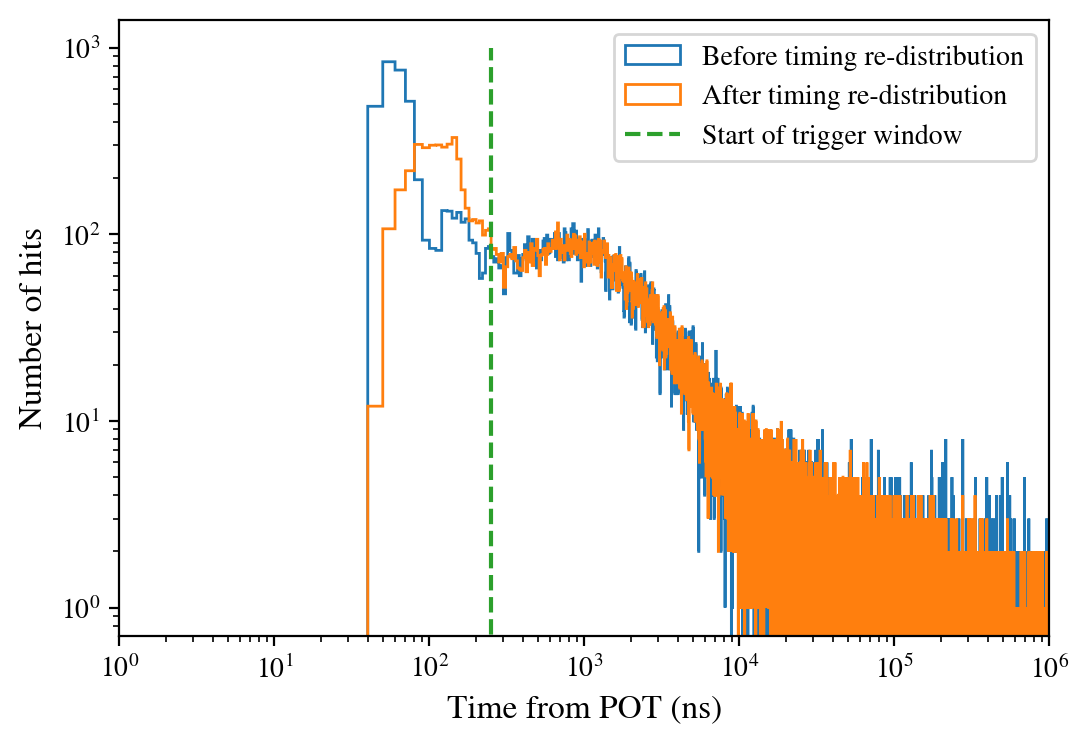

In [73]:
ntbins = 100000

# plt.hist(t, ntbins, range=[0, 1e5], histtype='step')
plt.hist(bunch1_ts, ntbins, range=[0, 1e6], histtype='step', label='Before timing re-distribution')
plt.hist(bunch1_ts_real, ntbins, range=[0, 1e6], histtype='step', label='After timing re-distribution')
plt.vlines(250, 0, 1e3, ls='--', colors='tab:green', label='Start of trigger window')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time from POT (ns)')
plt.ylabel('Number of hits')
plt.xlim(1, 1e6)
plt.legend()

In [23]:
bunch1_UO = bunch1_seg[(bunch1_hod==0) & (bunch1_cry==0)]
bunch1_UI = bunch1_seg[(bunch1_hod==0) & (bunch1_cry==1)]
bunch1_DO = bunch1_seg[(bunch1_hod==1) & (bunch1_cry==0)]
bunch1_DI = bunch1_seg[(bunch1_hod==1) & (bunch1_cry==1)]


In [24]:
bunch1_is, bunch1_seg
# seg[22349]

(array([ 43395,   2802,   4357, ...,  53010,  42196, 110513]),
 array([40., 63., 16., ..., 36.,  9., 52.]))

In [25]:
counter_is = {i : [] for i in range(256)}
# counter_is

for i in range(nhitsperbunch):
        if bunch1_cry[i]==0:
            if bunch1_hod[i]==0:
                counter_is[bunch1_seg[i]].append(i)
            elif bunch1_hod[i]==0:
                counter_is[bunch1_seg[i]+64].append(i)
        elif bunch1_cry[i]==1:
            if bunch1_hod[i]==0:
                counter_is[bunch1_seg[i]+128].append(i)
            elif bunch1_hod[i]==1:
                counter_is[bunch1_seg[i]+192].append(i)

In [26]:
# for i in range(50000):
#     for j in range(50000):
#         a = i +j

In [27]:
len(counter_is[0]), len(counter_is[148])

(284, 137)

/var/folders/gn/6k22_3_d37b4pwtr1ffv1fjr0000gn/T/ipykernel_1430/2636046115.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1e6)


(0.5011872336272722, 1000000.0)

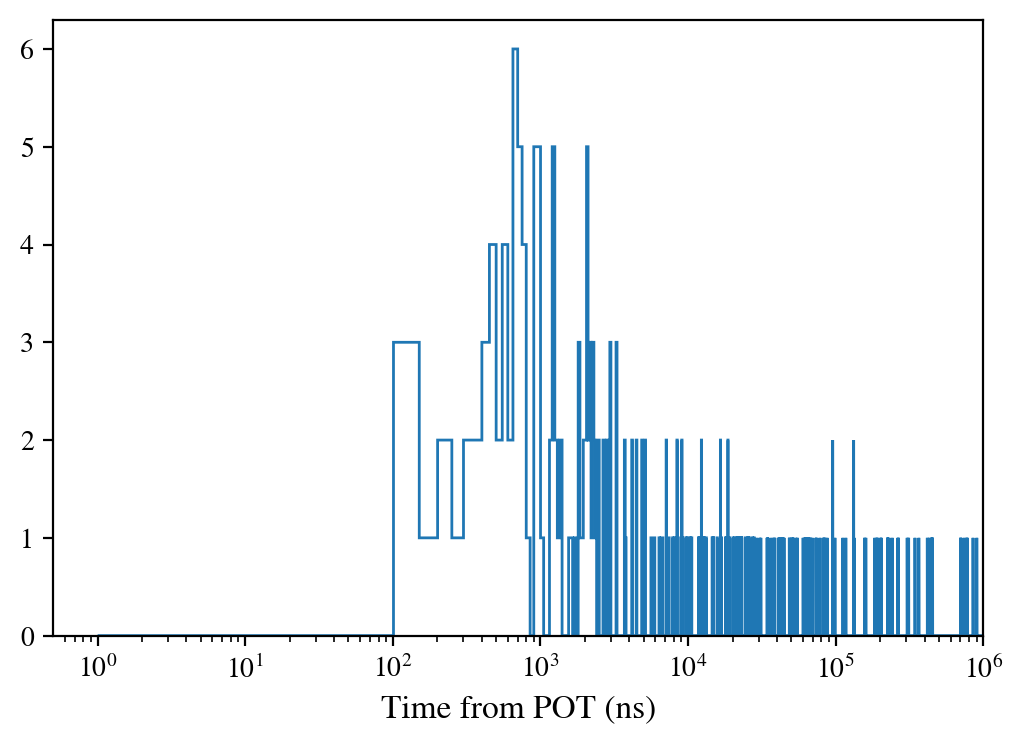

In [28]:
counter1_ts = np.array([bunch1_ts[i] for i in counter_is[0]])
counter1_ts_real = np.array([bunch1_ts_real[i] for i in counter_is[0]])

# plt.hist(counter1_ts, 50000, histtype='step')
plt.hist(counter1_ts_real, 20000, range=[1, 1e6], histtype='step')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Time from POT (ns)')
plt.xlim(0, 1e6)

In [29]:
def getCounterEneDep(counter, ts, dE, dt, cumul=True):
    nhits = len(counter)
    eneDep = np.zeros(nhits)
    # cc = 0
    for ic in range(nhits):
        ihit = counter[ic]
        eneDep[ic] = dE[ihit]
        if cumul==True:
            for jc in range(nhits):
                if abs(ts[ic]-ts[jc]) <= dt:
                    # cc+=1
                    jhit = counter[jc]
                    eneDep[ic] += dE[jhit]
    # print(cc)
    return eneDep

def nhitsByThresh(counter, ts, dE, dt, thresholds, cumul=True):
    nhits = []
    for th in thresholds:
        eneDep = getCounterEneDep(counter, ts, dE, dt, cumul)
        nhits.append(len(eneDep[eneDep>th]))
    return np.array(nhits)


(1, 1000000.0)

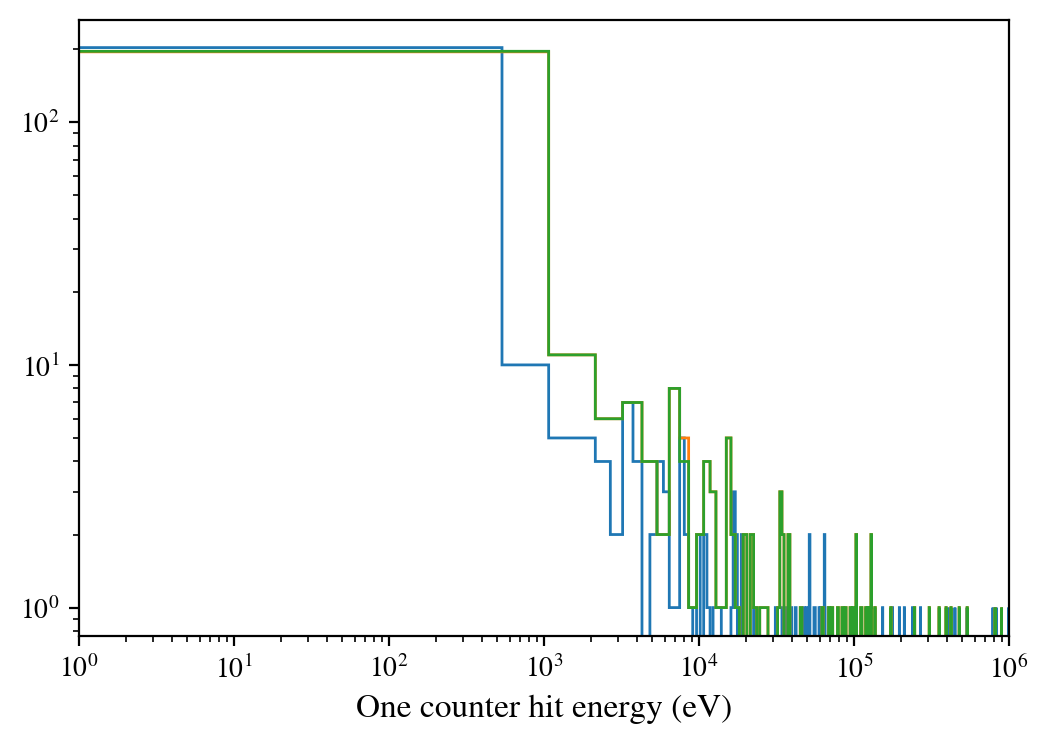

In [30]:
eneDep = getCounterEneDep(counter_is[1], bunch1_ts, bunch1_dE, dt=1, cumul=False)
eneDep2 = getCounterEneDep(counter_is[1], bunch1_ts, bunch1_dE, dt=1, cumul=True)
eneDep3 = getCounterEneDep(counter_is[1], bunch1_ts_real, bunch1_dE, dt=1, cumul=True)

plt.hist(1e6*eneDep, 10000, histtype='step')
plt.hist(1e6*eneDep2, 10000, histtype='step')
plt.hist(1e6*eneDep3, 10000, histtype='step')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('One counter hit energy (eV)')
plt.xlim(1, 1e6)

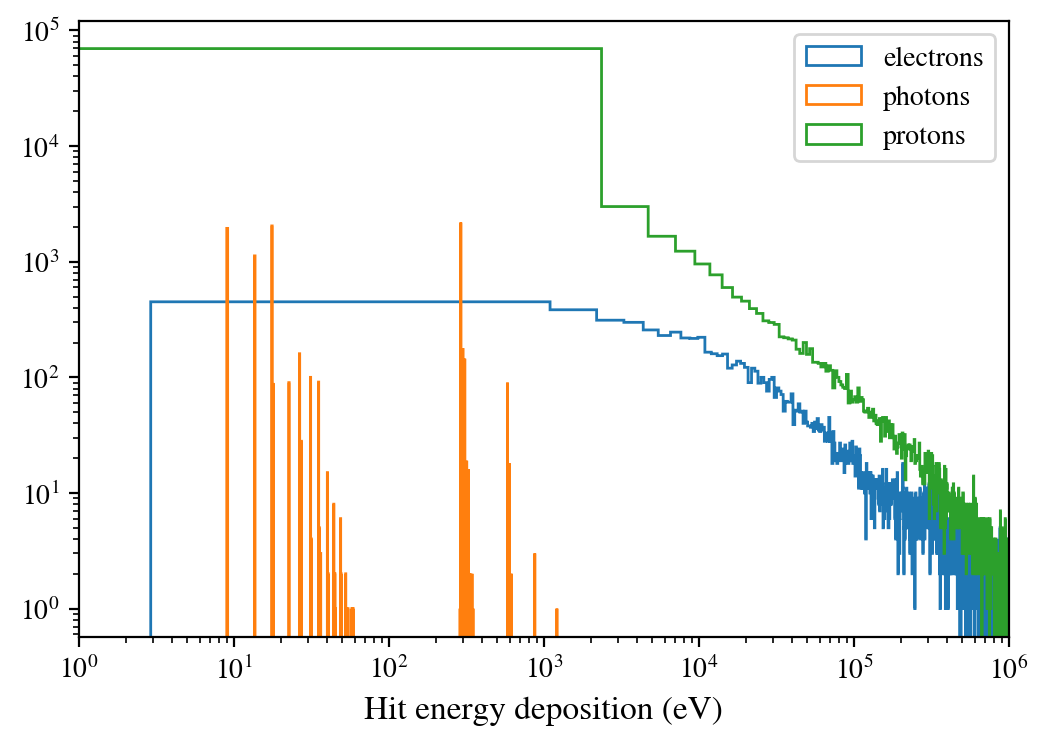

In [31]:
plt.hist(1e6*dE[pid==11], 10000, histtype='step', label="electrons")
plt.hist(1e6*dE[pid==22], 10000, histtype='step', label="photons")
plt.hist(1e6*dE[pid==2212], 10000, histtype='step', label="protons")
# plt.hist(eneDep2, histtype='step')
# plt.hist(bunch1_dE, histtype='step')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hit energy deposition (eV)')
plt.xlim(1, 1e6)
plt.legend()

In [32]:
eneTresh = 0.1

len(bunch1_dE), len(bunch1_dE[bunch1_dE>eneTresh])

(53173, 4234)

In [33]:
1e-6*(Nhits/256)/simTime, 1e-6*(nhitsperbunch/256)/bunchDt

(157.83464333206686, 157.83209061550153)

In [34]:
avgNhitsPerBunch = len(bunch1_dE[bunch1_dE>eneTresh])

avgNhitsPerBunch/256, 1e-6*(avgNhitsPerBunch/256)/bunchDt

(16.5390625, 12.567676671732523)

In [35]:
len(eneDep[eneDep>eneTresh]), len(eneDep2[eneDep2>eneTresh])

(16, 28)

In [36]:
len(pid[pid==11]), len(pid[pid==22]), len(pid[pid==2212])

(11462, 8559, 89098)

In [37]:
len(pid[(pid==11) & (dE>eneTresh)]), len(pid[(pid==22) & (dE>eneTresh)]), len(pid[(pid==2212) & (dE>eneTresh)])

(4160, 0, 4885)

In [38]:
nhits_cth = []
thresholds = np.arange(0.025, 0.5, 0.025)
for ic in range(256):
    nhits = nhitsByThresh(counter_is[ic], bunch1_ts_real, bunch1_dE, 1, thresholds, cumul=True)
    nhits_cth.append(nhits)
nhits_cth = np.array(nhits_cth)

In [39]:
nhits_cth_avg, nhits_cth_std = np.mean(nhits_cth, axis=0), np.std(nhits_cth, axis=0)

7.598784194528875


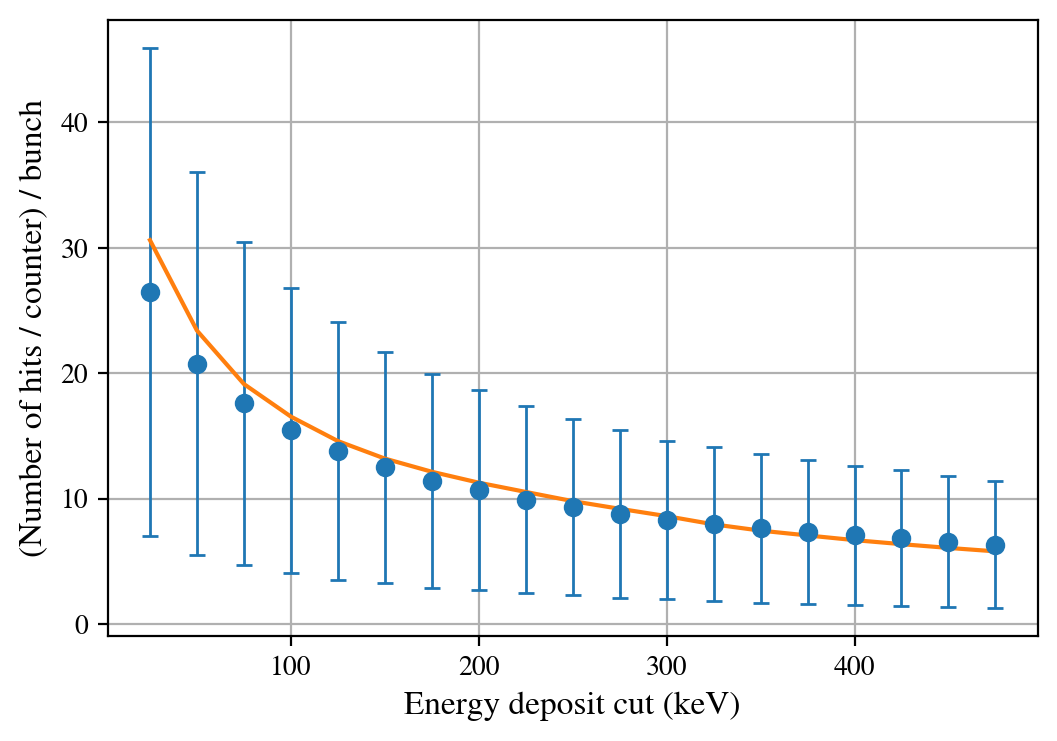

In [40]:
# thresholds = np.arange(0.025, 0.5, 0.025)
# nhits = nhitsByThresh(counter_is[1], bunch1_ts, bunch1_dE, 1, thresholds, cumul=True)

nhits_cth_simple = np.array([len(bunch1_dE[bunch1_dE>th]) for th in thresholds])

plt.errorbar(1e3*thresholds, nhits_cth_avg, nhits_cth_std, 0, 'o', elinewidth=1, capsize=3)
plt.plot(1e3*thresholds, nhits_cth_simple/256, '-')
plt.plot()
# plt.ylim(0, 60)
# plt.xlim(0, 500)
plt.grid()
plt.xlabel("Energy deposit cut (keV)")
plt.ylabel("(Number of hits / counter) / bunch")
print(1e-6*10/bunchDt)

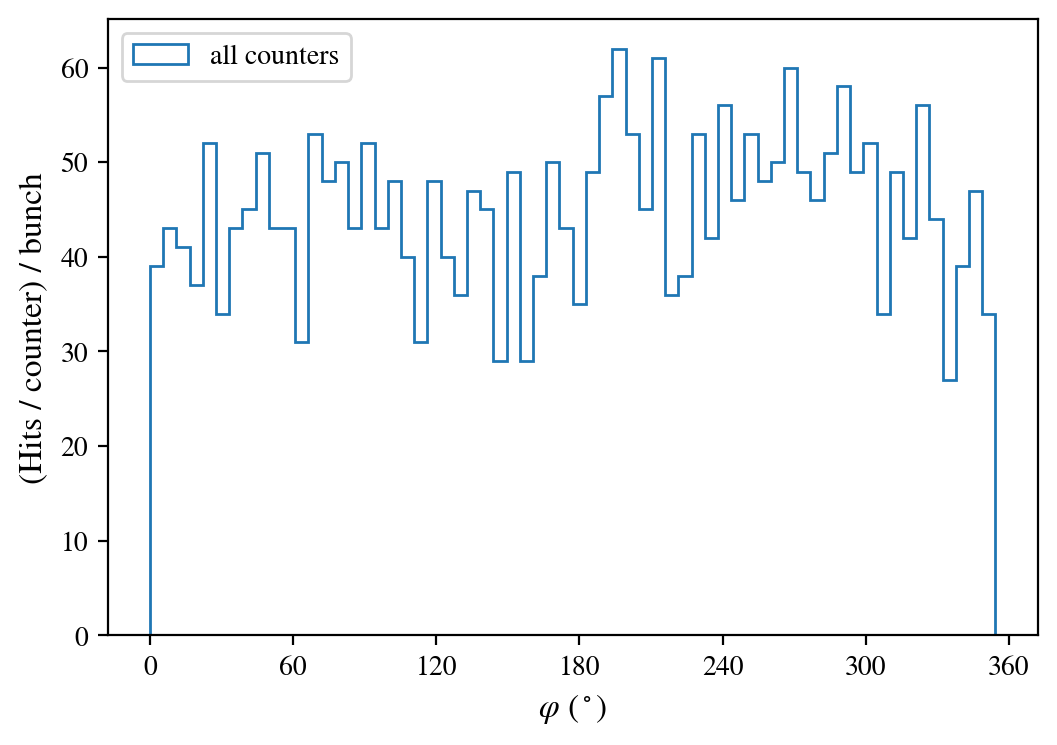

In [41]:
hTOT = plt.hist(bunch1_seg[bunch1_dE>0.2], histtype='step', bins=64, label="all counters")
plt.xticks(np.linspace(0, 64, 7), np.linspace(0, 360, 7).astype(int))
plt.xlabel(r"$\varphi$ $(^\circ)$")
plt.ylabel("(Hits / counter) / bunch")
plt.legend(ncol=2)
# plt.ylim(0, 3e8)

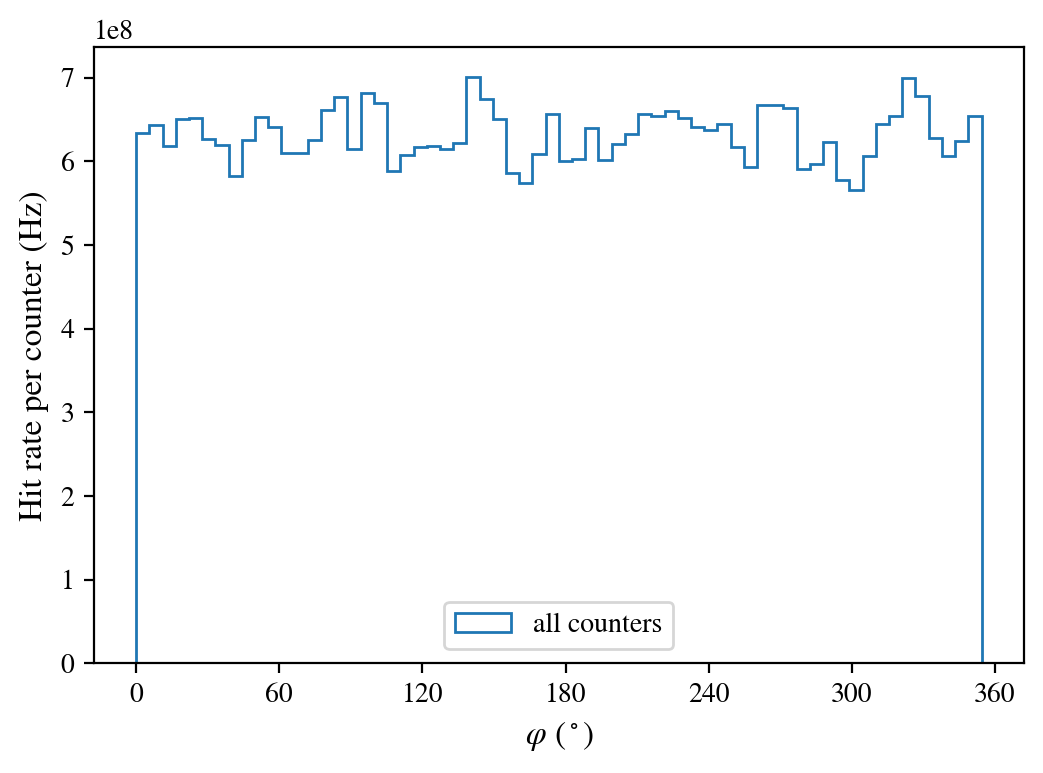

In [42]:


hTOT = plt.hist(seg, histtype='step', bins=64, label="all counters", weights=(1/simTime)*np.ones_like(seg))
plt.xticks(np.linspace(0, 64, 7), np.linspace(0, 360, 7).astype(int))
plt.xlabel(r"$\varphi$ $(^\circ)$")
plt.ylabel("Hit rate per counter (Hz)")
plt.legend(ncol=2)
# plt.ylim(0, 3e8)

In [43]:
def binx(bins):
    x = []
    for i in range(len(bins)-1):
        x.append( (bins[i]+bins[i+1])/2 )
    return np.array(x)

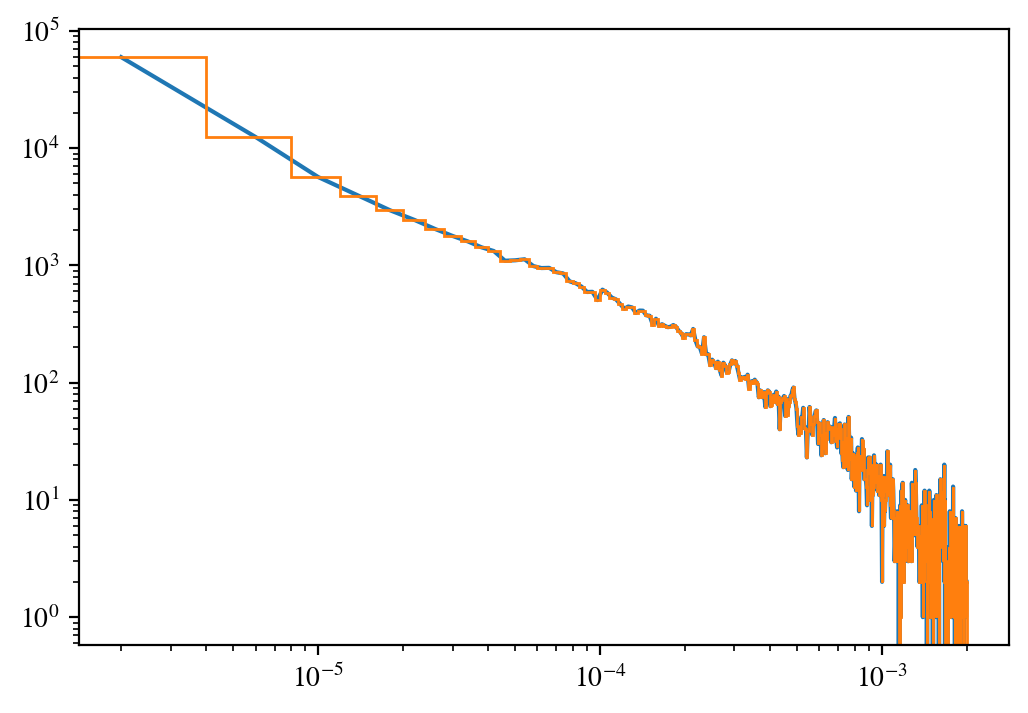

In [44]:
ts = 1e-9*t  ## in seconds
ntbins = 500
tmax = 1e-9*2e6  ## in seconds
binDt = tmax/ntbins

hitDist, tbins = np.histogram(ts, bins=ntbins, range=(0, tmax))
txs = binx(tbins)

hitRates = hitDist / binDt

plt.plot(txs, hitDist)
plt.hist(ts, ntbins, histtype='step', range=(0, tmax))
# plt.plot(txs, hitRates)
# plt.plot(txs, hitDist)


# plt.hist(1e-9*t, 200, histtype='step')
plt.yscale('log')
plt.xscale('log')
# plt.xlabel("Hit time (s)")

In [45]:
print("{:.2e}".format(np.sum(ts)/Nhits))
print("{:.2e}".format(np.mean(ts)))

8.26e-05
8.26e-05


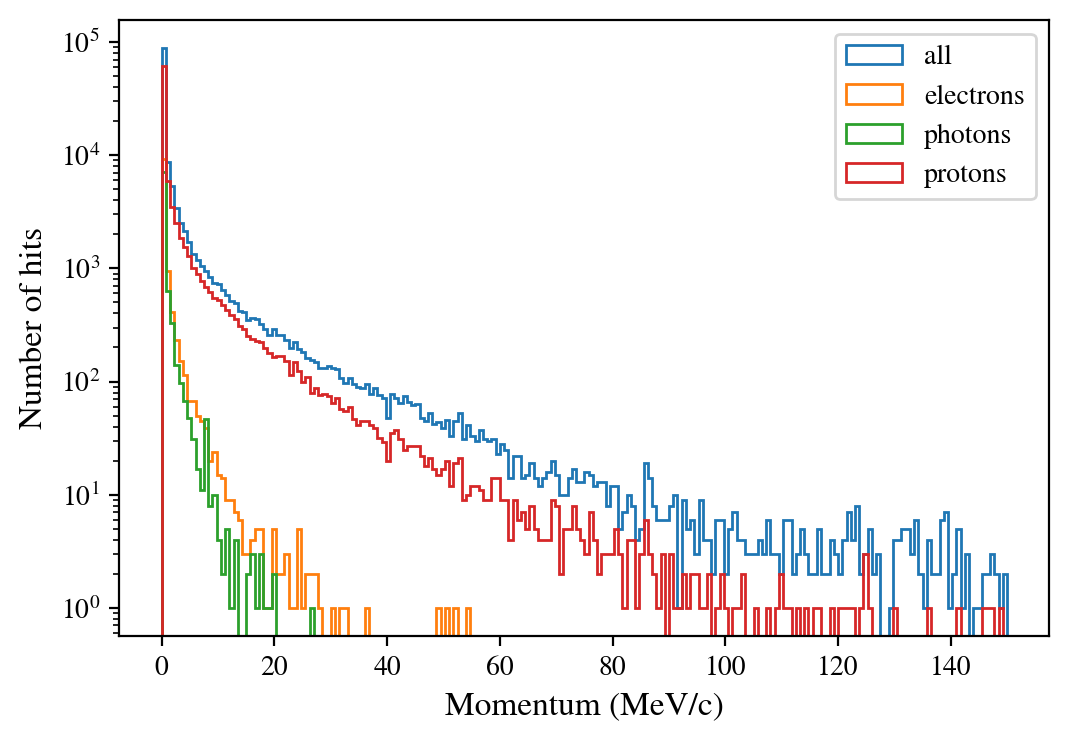

In [46]:
# ipart = 11
hist_range = (0, 150)
nbins = 200
binstep = (hist_range[1]-hist_range[0])/nbins

ys, bins = np.histogram(p2, nbins, range=hist_range)
intRate = np.sum(ys) / simTime

plt.hist(p2, nbins, hist_range, histtype='step', label='all')
plt.hist(p2[pid==11], nbins, hist_range, histtype='step', label='electrons')
plt.hist(p2[pid==22], nbins, hist_range, histtype='step', label='photons')
plt.hist(p2[pid==2212], nbins, hist_range, histtype='step', label='protons')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel("Momentum (MeV/c)")
plt.ylabel("Number of hits")
plt.legend()

Text(0, 0.5, 'y (mm)')

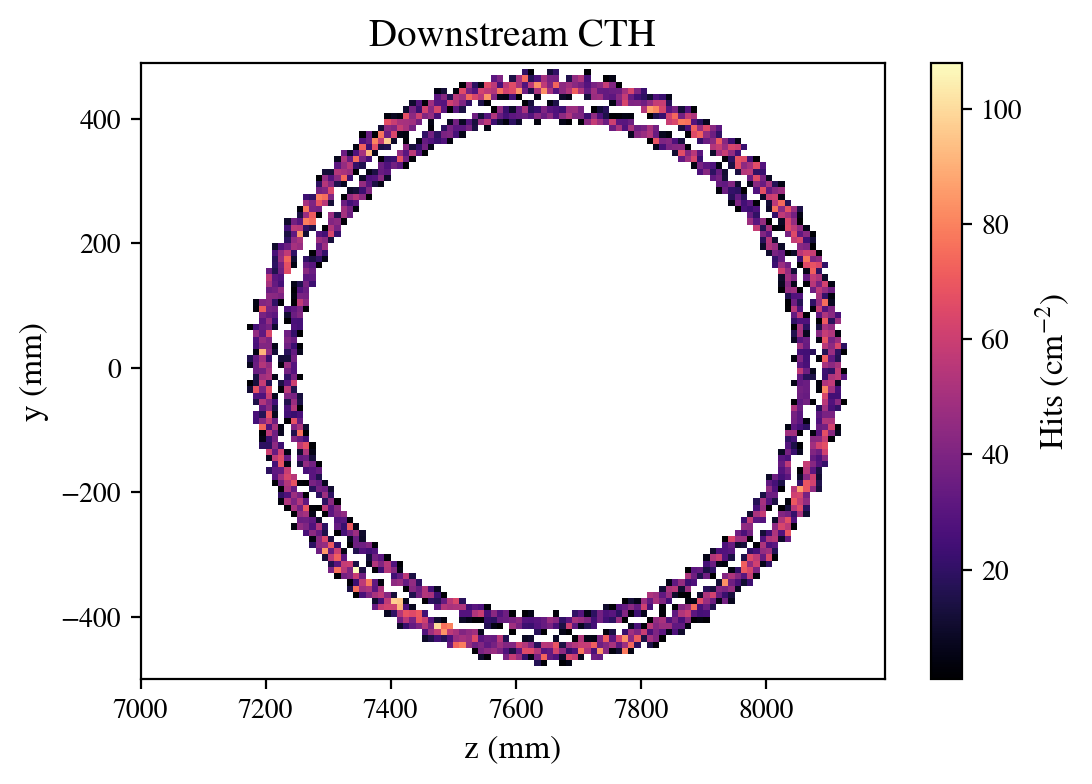

In [47]:
# ipart = 11
hist_range = (5000, 8000)
nbins = 200
binstep = (hist_range[1]-hist_range[0])/nbins

# colmap = "YlOrRd"
colmap = "magma"

ys, bins = np.histogram(x, nbins, range=hist_range)
intRate = np.sum(ys) / simTime

xcut = 6700

xmin, xmax = 7000, 8200
ymin, ymax = -500, 500
nbinsx = int((xmax-xmin)/10)  ## 1 bin / mm^2
nbinsy = int((ymax-ymin)/10)  ## 1 bin / mm^2
dx = int((xmax-xmin)//nbinsx)
dy = int((ymax-ymin)//nbinsy)

fig, ax = plt.subplots()

h = ax.hist2d(z[x>xcut], y[x>xcut], bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)), cmap=colmap, cmin=0.1)
# h = ax.hist2d(z[x<xcut], y[x<xcut], bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)), cmap=colmap, cmin=1, weights=(1/simTime)*np.ones_like(z[x<xcut]))
# cb = fig.colorbar(h[3], label=r'Hit rate (s$^{-1}$.cm$^{-2}$)')
cb = fig.colorbar(h[3], label=r'Hits (cm$^{-2}$)')


plt.title("Downstream CTH", size=14)
plt.xlabel("z (mm)")
plt.ylabel("y (mm)")
# plt.hist2d(x[pid==11], y[pid==11], nbins, hist_range, histtype='step')
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()

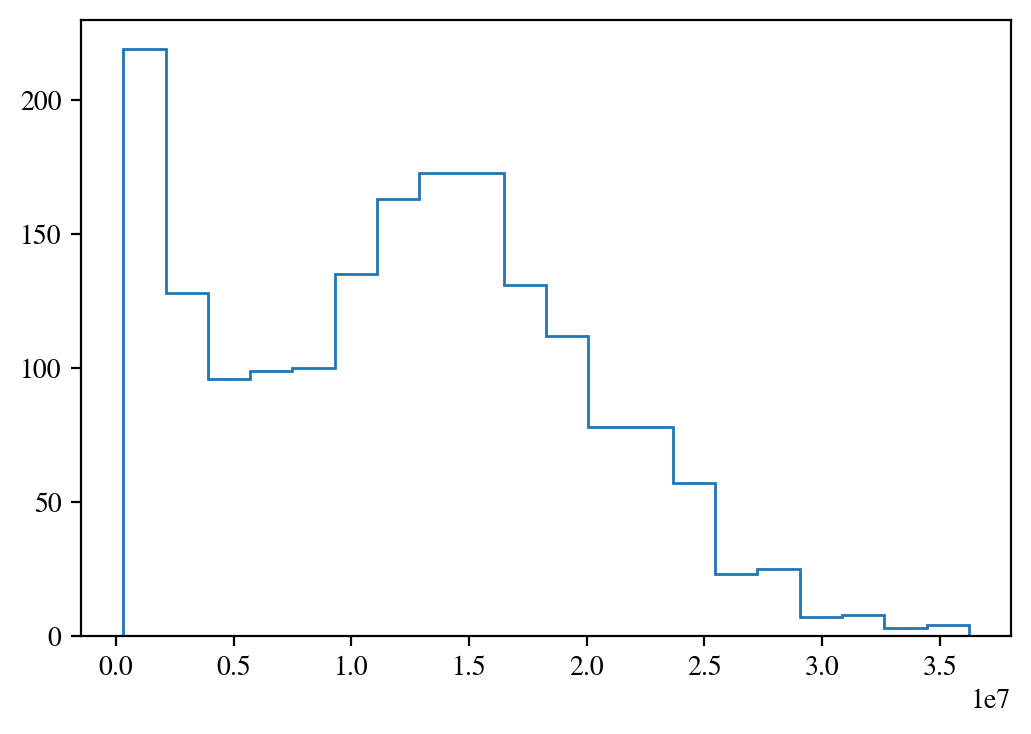

In [48]:
H, xedges, yedges = np.histogram2d(np.array(z)[x<xcut], np.array(y)[x<xcut], bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)))

hitRates = (1/simTime)*H.flatten()
hitRates = hitRates[hitRates>0]

plt.hist(hitRates, histtype='step', bins=20)
# plt.yscale('log')
print("")

In [49]:
# x[hod==0] ## upstream
# x[hod==1] ## downstream
# rho[cry==0] ## outer
# rho[cry==1] ## inner

upOuter = seg[(hod==0) & (cry==0)]
upInner = seg[(hod==0) & (cry==1)]
doOuter = seg[(hod==1) & (cry==0)]
doInner = seg[(hod==1) & (cry==1)]

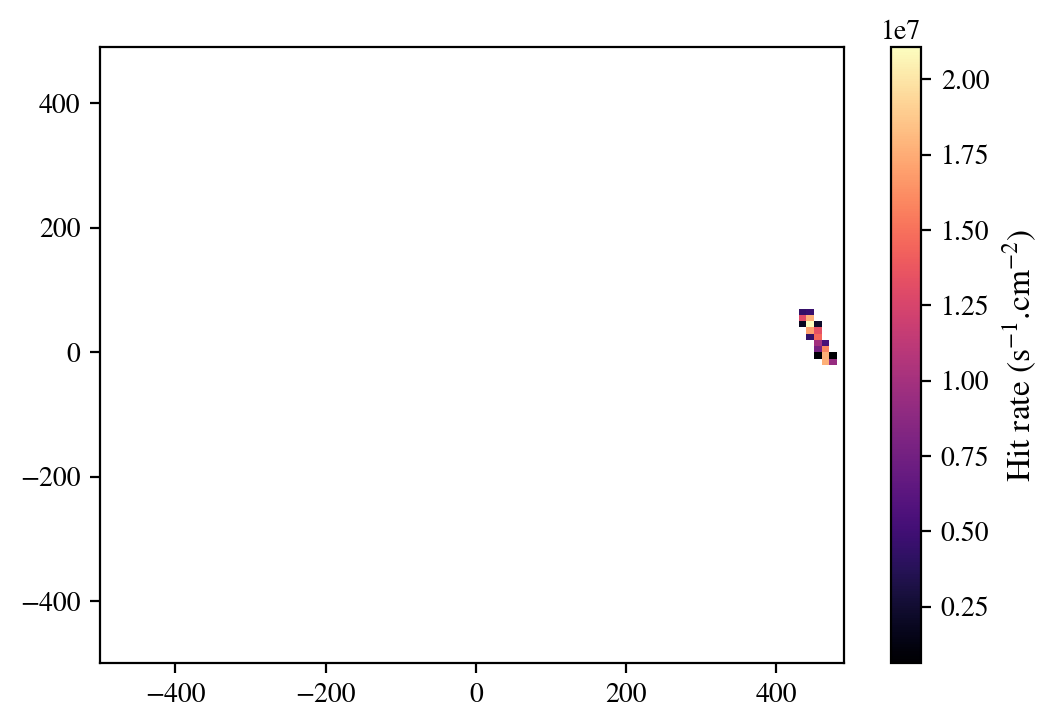

In [50]:
selec = (seg==0) & (hod==1) & (cry==0)

# ipart = 11
hist_range = (5000, 8000)
nbins = 200
binstep = (hist_range[1]-hist_range[0])/nbins

# colmap = "YlOrRd"
colmap = "magma"

ys, bins = np.histogram(x, nbins, range=hist_range)
intRate = np.sum(ys) / simTime

xcut = 6700

xmin, xmax = -500, 500
ymin, ymax = -500, 500
nbinsx = int((xmax-xmin)/10)  ## 1 bin / mm^2
nbinsy = int((ymax-ymin)/10)  ## 1 bin / mm^2
dx = int((xmax-xmin)//nbinsx)
dy = int((ymax-ymin)//nbinsy)

fig, ax = plt.subplots()

# h = ax.hist2d(np.array(z), np.array(y), bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)), cmap='seismic_r', norm=TwoSlopeNorm(0))
h = ax.hist2d(zc[selec], yc[selec], bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)), cmap=colmap, cmin=1, weights=(1/simTime)*np.ones_like(z[selec]))
cb = fig.colorbar(h[3], label=r'Hit rate (s$^{-1}$.cm$^{-2}$)')

# plt.title("Downstream CTH")
# plt.hist2d(x[pid==11], y[pid==11], nbins, hist_range, histtype='step')
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()

Text(0.5, 0, '$x$ (mm)')

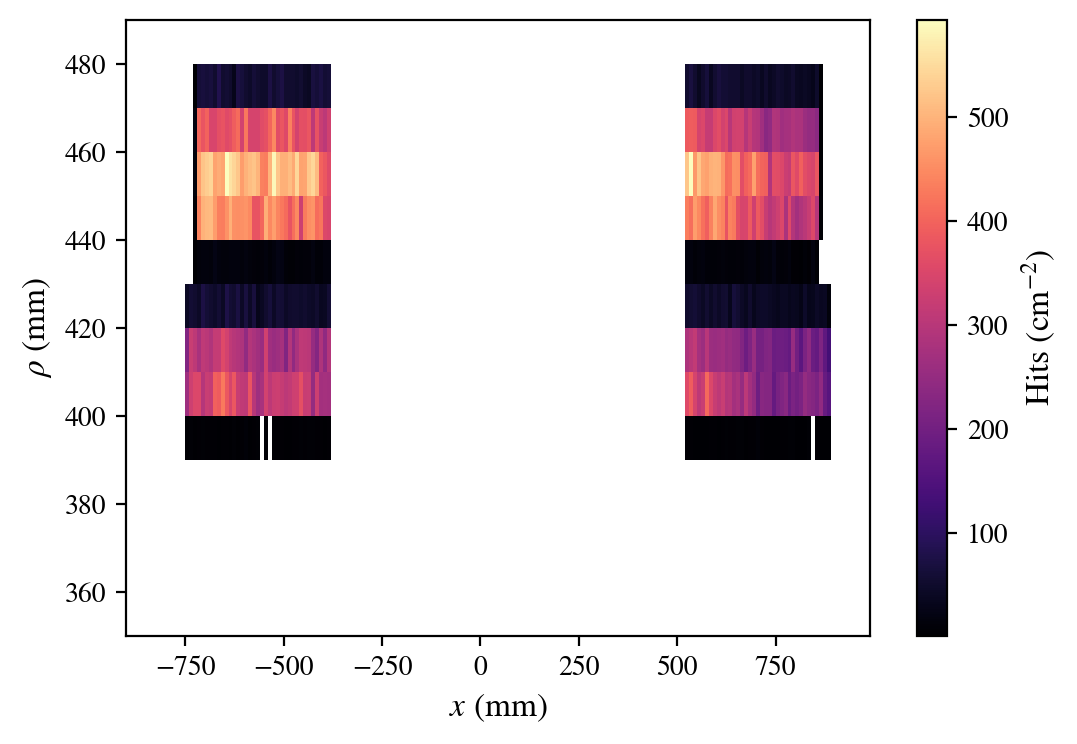

In [51]:
# selec = (hod==0)
selec = (hod>=0)

# ipart = 11
hist_range = (5000, 8000)
nbins = 200
binstep = (hist_range[1]-hist_range[0])/nbins

# colmap = "YlOrRd"
colmap = "magma"


ys, bins = np.histogram(x, nbins, range=hist_range)
intRate = np.sum(ys) / simTime

xmin, xmax = -900, 1000
ymin, ymax = 350, 500
nbinsx = int((xmax-xmin)/10)  ## 1 bin / cm^2
nbinsy = int((ymax-ymin)/10)  ## 1 bin / cm^2
dx = int((xmax-xmin)//nbinsx)
dy = int((ymax-ymin)//nbinsy)

fig, ax = plt.subplots()

h = ax.hist2d(xc[selec], rho[selec], bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)), cmap=colmap, cmin=1)
# h = ax.hist2d(xc[selec], rho[selec], bins=(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, dy)), cmap=colmap, cmin=1, weights=(1/simTime)*np.ones_like(xc[selec]))
# cb = fig.colorbar(h[3], label=r'Hit rate (s$^{-1}$.cm$^{-2}$)')
cb = fig.colorbar(h[3], label=r'Hits (cm$^{-2}$)')

# plt.hist2d(x[pid==11], y[pid==11], nbins, hist_range, histtype='step')
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel(r"$\rho$ (mm)")
plt.xlabel(r"$x$ (mm)")
# plt.legend()

In [52]:
len(upOuter)

46767

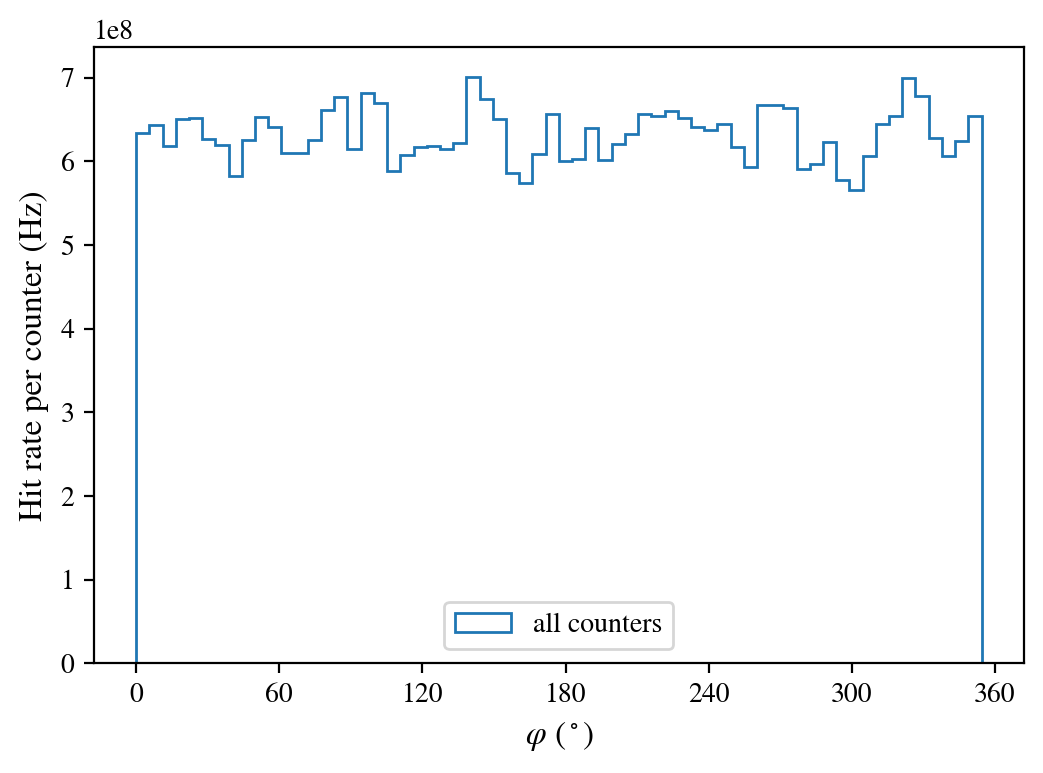

In [53]:
hTOT = plt.hist(seg, histtype='step', bins=64, label="all counters", weights=(1/simTime)*np.ones_like(seg))
plt.xticks(np.linspace(0, 64, 7), np.linspace(0, 360, 7).astype(int))
plt.xlabel(r"$\varphi$ $(^\circ)$")
plt.ylabel("Hit rate per counter (Hz)")
plt.legend(ncol=2)
# plt.ylim(0, 3e8)

(0.0, 300000000.0)

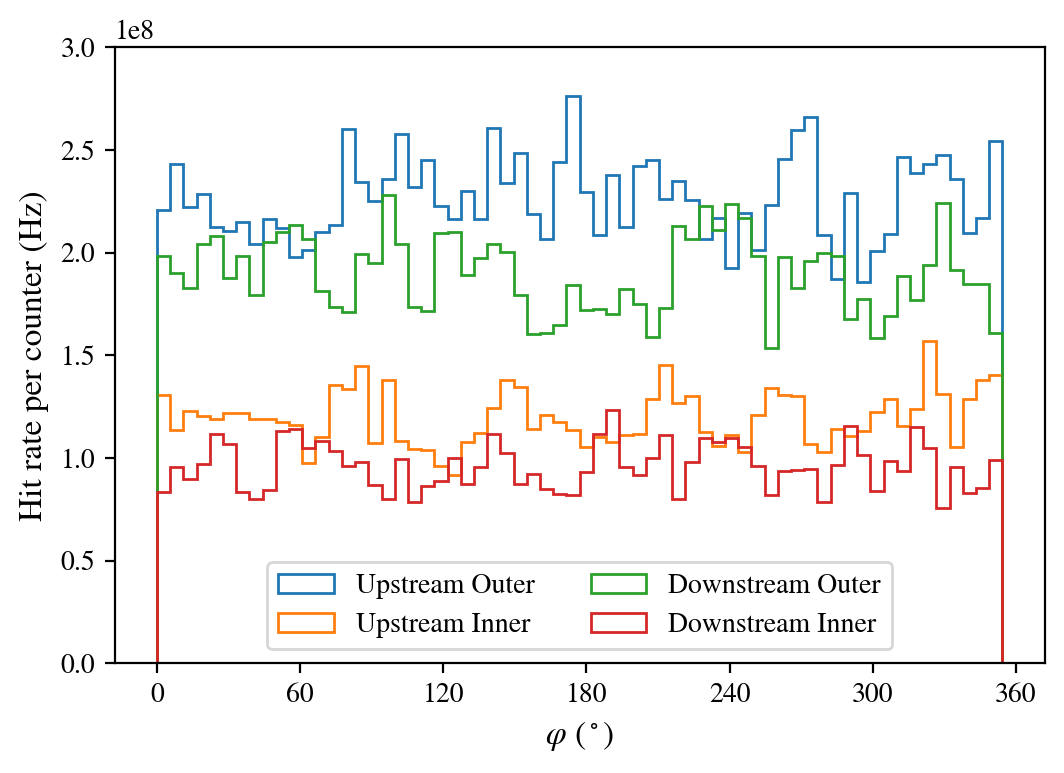

In [54]:

hUO = plt.hist(upOuter, histtype='step', bins=64, label="Upstream Outer", weights=(1/simTime)*np.ones_like(upOuter))
hUI = plt.hist(upInner, histtype='step', bins=64, label="Upstream Inner", weights=(1/simTime)*np.ones_like(upInner))
hDO = plt.hist(doOuter, histtype='step', bins=64, label="Downstream Outer", weights=(1/simTime)*np.ones_like(doOuter))
hDI = plt.hist(doInner, histtype='step', bins=64, label="Downstream Inner", weights=(1/simTime)*np.ones_like(doInner))
plt.xticks(np.linspace(0, 64, 7), np.linspace(0, 360, 7).astype(int))
plt.xlabel(r"$\varphi$ $(^\circ)$")
plt.ylabel("Hit rate per counter (Hz)")
plt.legend(ncol=2)
plt.ylim(0, 3e8)

In [55]:
hrpcUO = np.mean(hUO[0])
hrpcUI = np.mean(hUI[0])
hrpcDO = np.mean(hDO[0])
hrpcDI = np.mean(hDI[0])
hrpcTOT = np.mean(hTOT[0])/4
print("hrpc upOuter = {:.2e} Hz".format(hrpcUO))
print("hrpc upInner = {:.2e} Hz".format(hrpcUI))
print("hrpc doOuter = {:.2e} Hz".format(hrpcDO))
print("hrpc doInner = {:.2e} Hz".format(hrpcDI))
print("hrpc total = {:.2e} Hz".format(hrpcTOT))

hrpc upOuter = 2.26e+08 Hz
hrpc upInner = 1.19e+08 Hz
hrpc doOuter = 1.90e+08 Hz
hrpc doInner = 9.60e+07 Hz
hrpc total = 1.58e+08 Hz


In [56]:
def singleCounterRate(R4f, tau):
    ### single counter hit rate from 4f coincidence hit rate (Hz) in time window tau (s)
    return (R4f / (2*tau)**3)**0.25

def trigger4fRate(R, tau):
    ### 4f coincidence trigger rate of 2 counters from single counter rate (Hz) in time window tau (s)
    return R**4 * (2*tau)**3

In [57]:
# trigger4fRate(1767e3, 10e-9)
# singleCounterRate(78, 10e-9)
singleCounterRate(100e3/128, 10e-9)

3143583.5742073385

In [58]:
100e3/128

781.25

In [59]:
print("{:.2e}".format(intRate))


4.04e+10


/opt/anaconda3/envs/PyTom/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 'CTH hits')

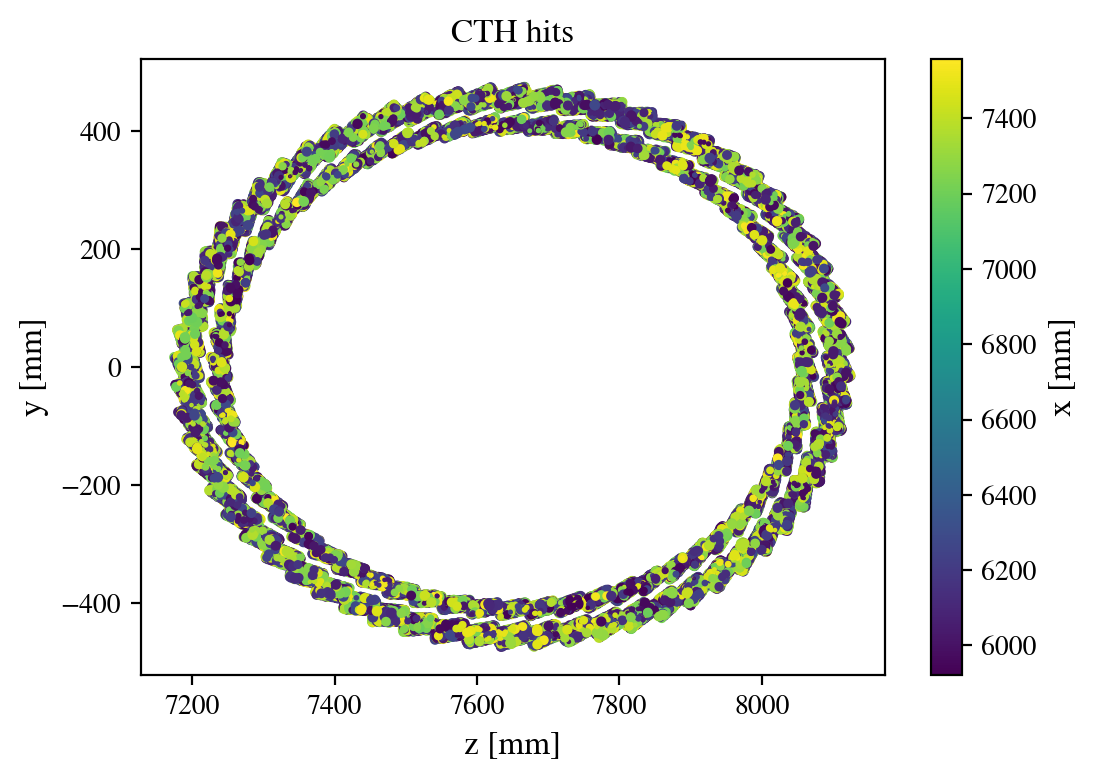

In [60]:
fig1, ax1 = plt.subplots()
sc1 = ax1.scatter(z, y, s=8+np.log10(dE), c=x)
ax1.set_ylabel('y [mm]')
ax1.set_xlabel('z [mm]')
fig1.colorbar(sc1, label='x [mm]')
ax1.set_title("CTH hits")

Text(0.5, 1.0, 'CTH hits')

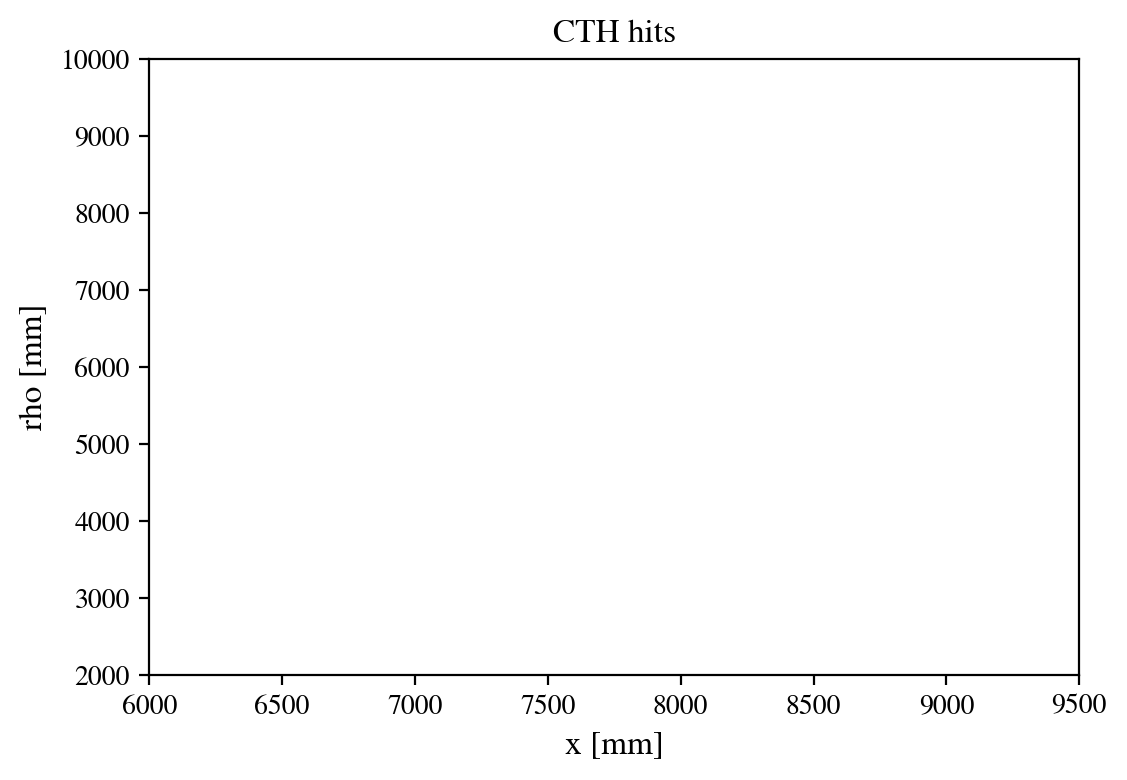

In [61]:
fig3, ax3 = plt.subplots()
sc3 = ax3.scatter(rho, x, s=8+np.log10(dE))
ax3.set_ylabel('rho [mm]')
ax3.set_xlabel('x [mm]')
ax3.set_xlim(6000, 9500)
ax3.set_ylim(2000, 10000)
ax3.set_title("CTH hits")

Text(0.5, 1.0, 'Primary particle origins')

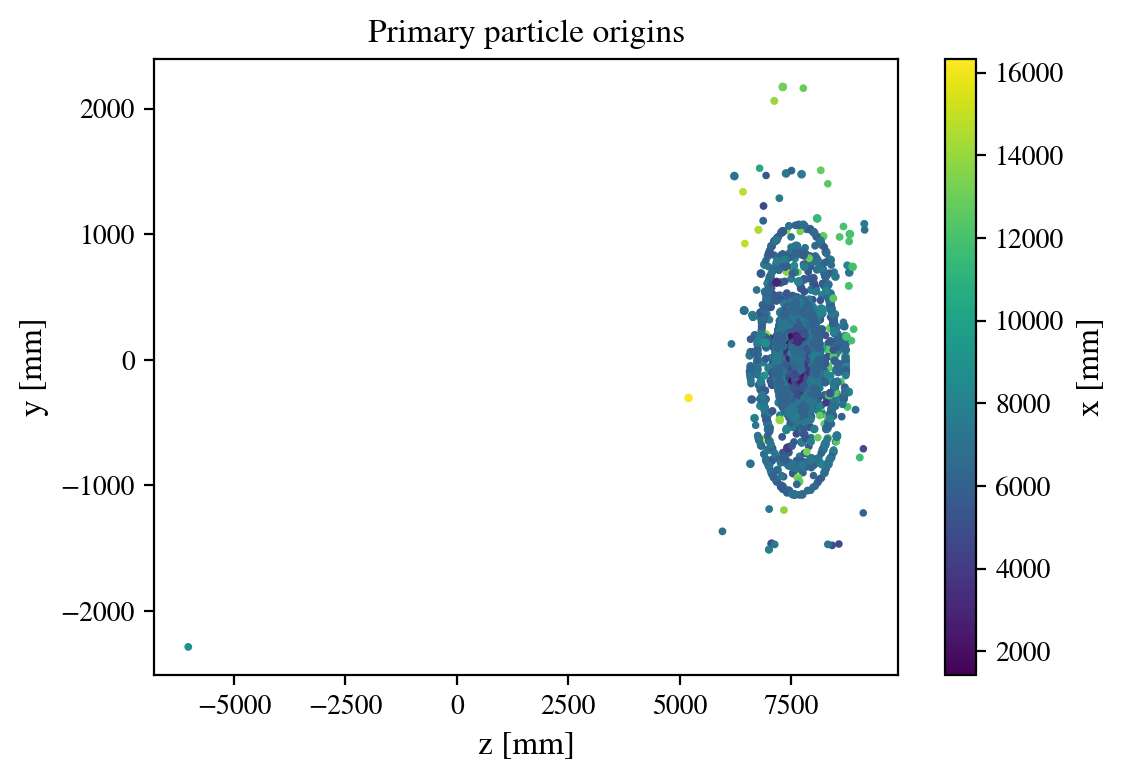

In [62]:
fig2, ax2 = plt.subplots()
sc2 = ax2.scatter(iz, iy, s=8+np.log10(dE), c=ix)
ax2.set_ylabel('y [mm]')
ax2.set_xlabel('z [mm]')
fig2.colorbar(sc2, label='x [mm]')
ax2.set_title("Primary particle origins")

(2000.0, 10000.0)

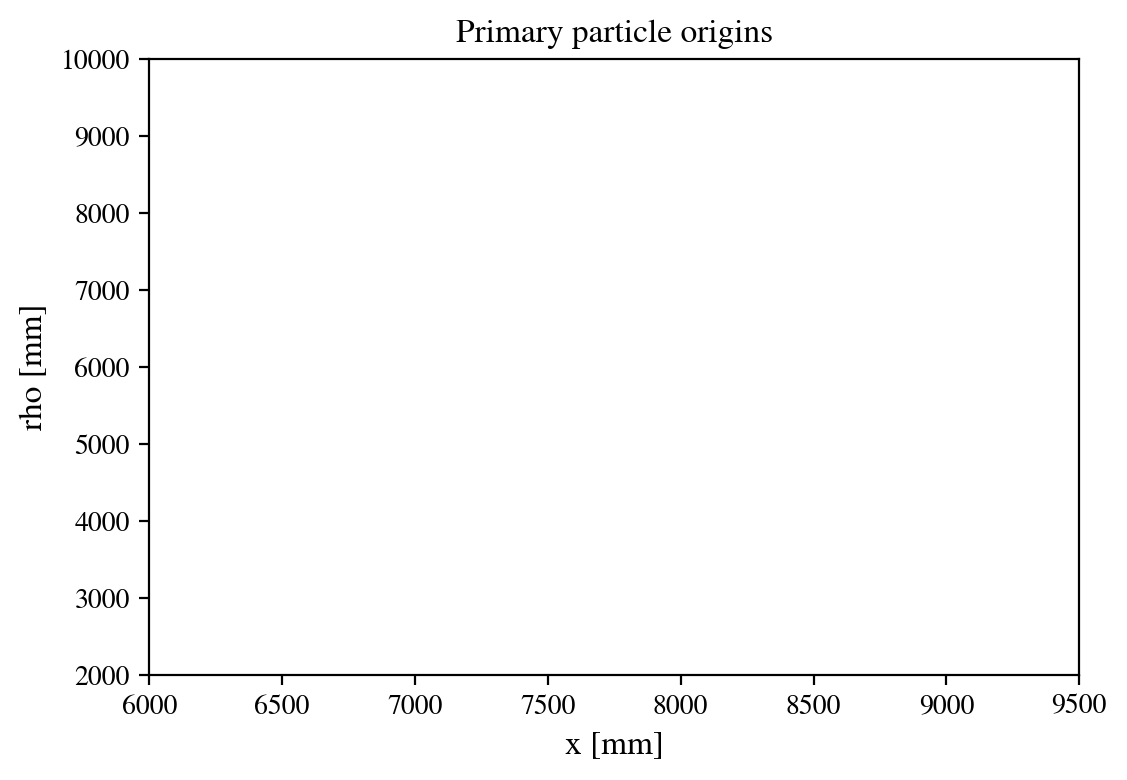

In [63]:
fig5, ax5 = plt.subplots()
# sc5 = ax5.scatter(irho, ix, s=8+np.log10(dE))
ax5.set_ylabel('rho [mm]')
ax5.set_xlabel('x [mm]')
ax5.set_title("Primary particle origins")
ax5.set_xlim(6000, 9500)
ax5.set_ylim(2000, 10000)

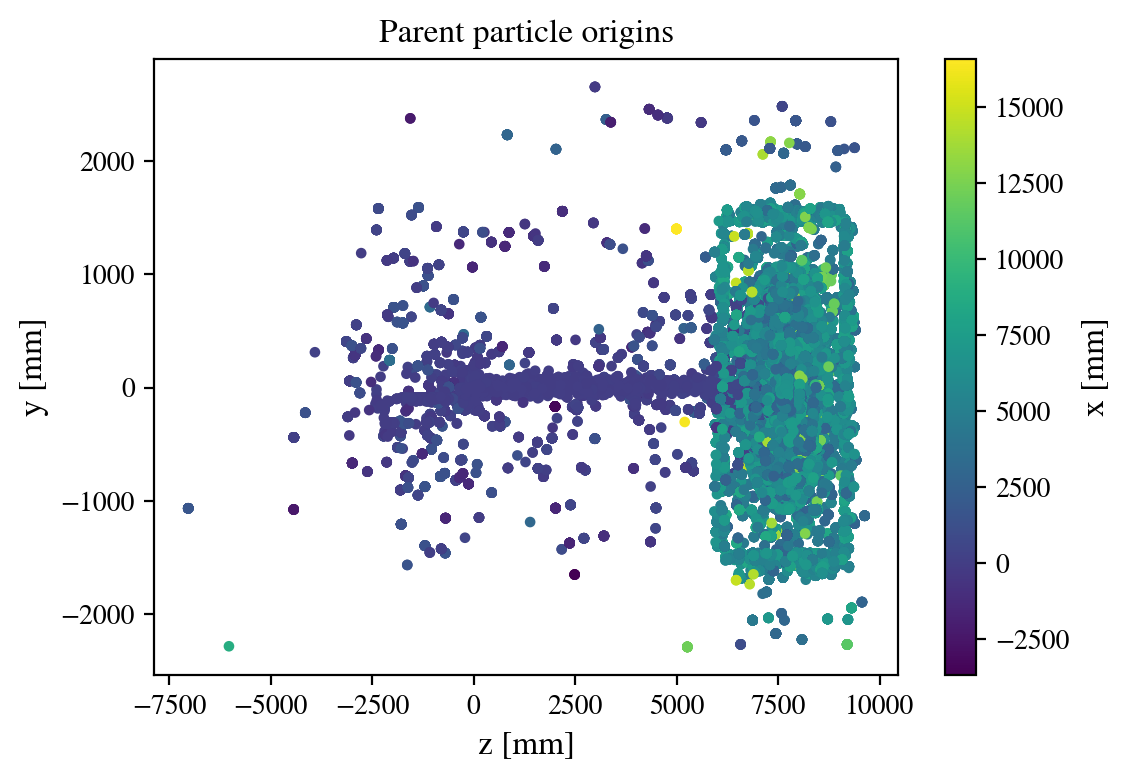

In [64]:
fig6, ax6 = plt.subplots()
sc6 = ax6.scatter(oz, oy, c=ox, s=8)
ax6.set_ylabel('y [mm]')
ax6.set_xlabel('z [mm]')
ax6.set_title("Parent particle origins")
fig6.colorbar(sc6, label='x [mm]')

(2000.0, 10000.0)

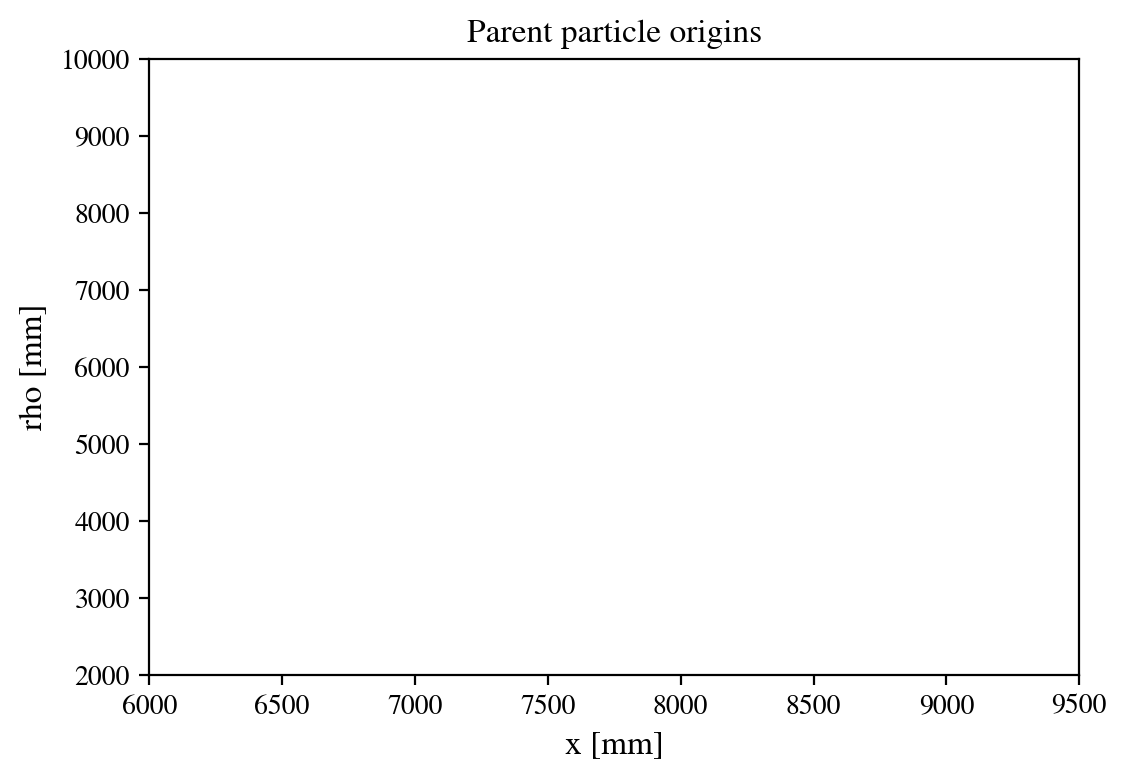

In [65]:
fig4, ax4 = plt.subplots()
# sc4 = ax4.scatter(orho, ox, s=8)
ax4.set_ylabel('rho [mm]')
ax4.set_xlabel('x [mm]')
ax4.set_title("Parent particle origins")
ax4.set_xlim(6000, 9500)
ax4.set_ylim(2000, 10000)